In [1]:
import numpy as np
import common_functions
from scipy.ndimage import rotate
import multiprocessing
import sys
import skimage as sk
import tifffile as tiff
import warnings
from functools import partial
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import norm
import statistics


In [2]:
def shape_finder_2D_v2(hull_lines, hull_mask, sum_lines, sum_mask, angle=40):
    '''
    Get the first approximation using hull and sum lines, delta degree = 20º
    - hull_lines is the epithelial obtained from hull mask
    - hull_mask is the gaussian or the line obtained using hull from front
    - sum_lines is the epithelial obtained from sum mask
    - sum_mask is the gaussian or the line obtained using hull from front
    - angle is the max rotation for the 2D image
    '''
    angles = [i for i in range(-angle, angle+1, 20)]
    # angles = [40]
    total_cell_mask = np.zeros(shape=(hull_lines.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_hull_lines = rotate(hull_lines, angle, reshape=False) # Be careful of the reshape=False
        rot_hull_mask = rotate(hull_mask, angle, reshape=False)
        rot_sum_lines = rotate(sum_lines, angle, reshape=False)
        rot_sum_mask = rotate(sum_mask, angle, reshape=False)
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_hull_lines.shape[1]):
            col_hull_lines = rot_hull_lines[:, i]
            max_pos_hull_lines = np.argmax(col_hull_lines == max(col_hull_lines))
            col_hull_mask = rot_hull_mask[:, i]
            max_pos_hull_mask = np.argmax(col_hull_mask == max(col_hull_mask))

            col_sum_lines = rot_sum_lines[:, i]
            max_pos_sum_lines = np.argmax(col_sum_lines == max(col_sum_lines))
            col_sum_mask = rot_sum_mask[:, i]
            max_pos_sum_mask = np.argmax(col_sum_mask == max(col_sum_mask))

            # print(max_pos_hull_lines, max_pos_hull_mask, abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask)


            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            if ((max_pos_hull_lines <= len(col_hull_lines)*0.90) and (max_pos_hull_lines >= len(col_hull_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_hull_lines) # Search for the first max

            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            elif ((max_pos_sum_lines <= len(col_sum_lines)*0.90) and (max_pos_sum_lines >= len(col_sum_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_sum_lines) # Search for the first max

            else:
                cell_border.append('-')
                # cell_border.append(max_pos_sum_lines) 

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_hull_lines)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)


In [3]:
# time_dome = str(4)
# folder_and_dome = str('./../../../../Desktop/dome70_fallinglineMove/70_denoised_tp')
# wd = folder_and_dome + time_dome

# image = sk.io.imread(wd+'.tif')
# image_r = common_functions.get_image_r(image)

# epithelial_hull = sk.io.imread(wd+'_hull_top_line_epithelial_0.tif')
# gaussian_hull = sk.io.imread(wd+'_hull_top_line_gaussian_0.tif')
# hull_top_line = sk.io.imread(wd+'_hull_top_line_0.tif')
# epithelial_sum = sk.io.imread(wd+'_sum_top_line_epithelial_0.tif')
# gaussian_sum = sk.io.imread(wd+'_sum_top_line_gaussian_0.tif')
# sum_top_line = sk.io.imread(wd+'_sum_top_line_0.tif')


# epithelial_hull_r = common_functions.get_image_r(epithelial_hull)
# gaussian_hull_r = common_functions.get_image_r(gaussian_hull)
# hull_top_line_r = common_functions.get_image_r(hull_top_line)
# epithelial_sum_r = common_functions.get_image_r(epithelial_sum)
# gaussian_sum_r = common_functions.get_image_r(gaussian_sum)
# sum_top_line_r = common_functions.get_image_r(sum_top_line)

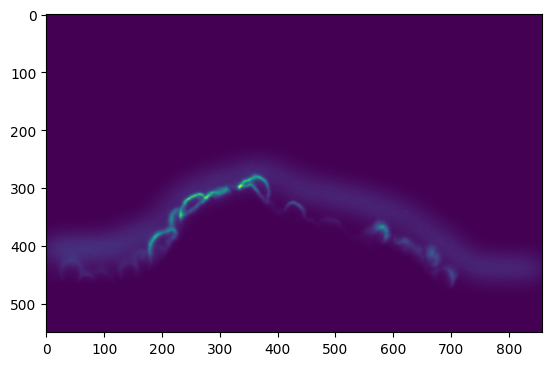

In [4]:
# y = 300
# plt.imshow(epithelial_hull_r[y])

In [5]:
# def get_distribution(arr):

#     mean, std = norm.fit(arr)

#     mu, _ = norm.fit(common_functions.normalize_image(np.cumsum(arr)))
#     mu = np.where(common_functions.normalize_image(np.cumsum(arr)) > mu)[0][0]
#     mu = mu/len(arr)

#     return round(mean, 5), round(std, 5), round(mu, 5)


# def shape_finder_2D_v3(image, epithelial_sum, gaussian_sum, angle=40):
#     warnings.filterwarnings("ignore", message="divide by zero encountered in scalar divide")
    
#     gaussian_sum = common_functions.normalize_image(gaussian_sum, 1)
#     image = common_functions.normalize_image(image, 1)

#     epithelial_sum = gaussian_sum*image

#     epithelial_sum = common_functions.normalize_image(epithelial_sum, 1)
#     gaussian_sum = common_functions.normalize_image(gaussian_sum, 1)


#     angles = [i for i in range(-angle, angle+1, 20)]
#     # angles = [-20]
#     total_cell_mask = np.zeros(shape=(epithelial_sum.shape))

#     for angle in angles:

#         ## Rotate all the images.
#         rot_epithelial_sum = rotate(epithelial_sum, angle, reshape=False)
#         rot_gaussian_sum = rotate(gaussian_sum, angle, reshape=False)
#         cell_border = []

        
#         x_plot = '640'

#         for x in range(rot_epithelial_sum.shape[1]):
#             mean_e, std_e, mu_e = get_distribution(common_functions.normalize_image(rot_epithelial_sum.transpose()[x]))
#             mean_g, std_g, mu_g = get_distribution(common_functions.normalize_image(rot_gaussian_sum.transpose()[x]))

#             max_e = rot_epithelial_sum.transpose()[x].max()
#             max_g = rot_gaussian_sum.transpose()[x].max()

#             position_e = np.argmax(rot_epithelial_sum.transpose()[x] == max_e)
#             position_g = np.argmax(rot_gaussian_sum.transpose()[x] == max_g)

#             mean_ey, std_ey, mu_ey = get_distribution(common_functions.normalize_image(rot_epithelial_sum[position_e]))
#             max_row_e = rot_epithelial_sum[position_e].max()

#             max_e = round(max_e, 5)
#             max_g = round(max_g, 5)

#             std_perc_diff = abs(std_e-std_g)/std_g # Std difference from the gaussian
#             max_row_perc_diff = abs(max_row_e-max_e)/max_row_e

#             if x_plot == x:

#                 print(f'Epithelial: Mean {mean_e}, std {std_e}, Mu {mu_e}, max value {max_e}, position {position_e}')
#                 print(f'Gaussian: Mean {mean_g}, std {std_g}, Mu {mu_g}, max value {max_g}, position {position_g}')
#                 print(f'Y epithelial in x {x}: Mean {mean_ey}, std {std_ey}, Mu {mu_ey}, Value compared to max: {max_e} {rot_epithelial_sum[position_e].max()} perc {max_row_perc_diff}')

#                 plt.figure(figsize=(20,12))
#                 plt.subplot(221)
#                 plt.imshow(rot_epithelial_sum)
#                 plt.axhline(position_e)
#                 plt.axvline(x)
#                 plt.subplot(222)
#                 plt.imshow(rot_gaussian_sum)
#                 plt.axhline(position_g)
#                 plt.axvline(x)

#                 plt.subplot(223)
#                 plt.plot(common_functions.normalize_image(rot_epithelial_sum.transpose()[x]), label='epithelial')
#                 plt.plot(common_functions.normalize_image(rot_gaussian_sum.transpose()[x]), label='gaussian')
#                 plt.legend()

#                 print(f'Std perc = {round(std_perc_diff, 5)}')

#             if max_g >= 0.5 and std_g <= 0.4: # set the minimum of gaussian as dottamine has detected something
#                 if std_perc_diff >= 0.15 and std_e <= 0.2: # set the minimum of % difference from gaussian to epithelial
#                     if max_row_perc_diff <= 1: # set the minimum of % difference from col max to row max
#                         cell_border.append(position_e)
#                         print('yes') if x_plot == x else None
#                     else:
#                         cell_border.append('-')
#                 else:
#                     cell_border.append('-')
#             else:
#                 cell_border.append('-')

#         ## Put the positions in a matrix as we have done with the smoothed line before.
#         cell_top_mask_rot = np.zeros_like(rot_epithelial_sum)
#         for i in range(cell_top_mask_rot.shape[1]):
#             if cell_border[i] != '-':
#                 cell_top_mask_rot[cell_border[i], i] = 1
        

#         ## Rotate the matrix to have it horizontal as the original image.
#         horizontal_cut = 10
#         cell_top_mask_rot[:horizontal_cut, :] = 0
#         cell_top_mask_rot[-horizontal_cut:, :] = 0
#         cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
#         cell_top_mask_rot[cell_top_mask_rot < 0] = 0
#         # cell_top_mask_rot[cell_top_mask_rot > cell_top_mask_rot.shape[1]-200] = 0
#         horizontal_cut = 10
#         cell_top_mask_rot[:, :horizontal_cut] = 0
#         cell_top_mask_rot[:, -horizontal_cut:] = 0
#         total_cell_mask += cell_top_mask_rot

#     return np.array(total_cell_mask)


In [204]:
## shape finder for second tiime
def get_distribution(arr):

    mean, std = norm.fit(arr)
    mu, _ = norm.fit(common_functions.normalize_image(np.cumsum(arr)))
    mu = np.where(common_functions.normalize_image(np.cumsum(arr)) > mu)[0][0]
    mu = mu/len(arr)

    return round(mean, 5), round(std, 5), round(mu, 5)


def get_2d_mask_zeros(image, increment = 0):
    """
    returns a 2d mask that has looked from top the first pixel != 0
    """
    outline = np.zeros(shape=(image.shape))
    first_nonzero_indices = np.argmax(image != 0, axis=0)
    first_nonzero_indices[first_nonzero_indices == 0] = image.shape[0]
    first_nonzero_indices += increment
    if increment <= 0:
        first_nonzero_indices[first_nonzero_indices < 0] = 0
    if increment >= 0:
        first_nonzero_indices[first_nonzero_indices > image.shape[0]] = image.shape[0]
    mask = np.indices(image.shape)[0] >= first_nonzero_indices[None]
    outline[mask] = 1

    return outline

def get_3d_mask_zeros(image, increment = 0):
    """
    returns a 2d mask that has looked from top the first pixel != 0
    """
    outline = np.zeros(shape=(image.shape))
    first_nonzero_indices = np.argmax(image != 0, axis=1)
    if increment <= 0:
        first_nonzero_indices[first_nonzero_indices < 0] = 0
    if increment >= 0:
        first_nonzero_indices[first_nonzero_indices > image.shape[1]] = image.shape[1]
    mask = np.indices(image.shape)[1] >= first_nonzero_indices[:, None]
    outline[mask] = 1

    return outline

def get_2d_outline(mask):
    # Find the index of the first nonzero element in each row
    first_nonzero_indices = np.argmax(mask != 0, axis=0)
    # print(first_nonzero_indices)

    outline = np.zeros(mask.shape)

    outline[first_nonzero_indices, np.array(list(range(mask.shape[1])))] = 1

    return outline





def shape_finder_2D_v3(image, gaussian, angle=40, moveLine=20):
    warnings.filterwarnings("ignore", message="divide by zero encountered in scalar divide")
    
    gaussian = common_functions.normalize_image(gaussian, 1)
    image = common_functions.normalize_image(image, 1)

    epithelial = gaussian*image

    epithelial = common_functions.normalize_image(epithelial, 1)
    gaussian = common_functions.normalize_image(gaussian, 1)
    mask = get_2d_mask_zeros(image)
    outline = get_2d_outline(mask)

    angles = [i for i in range(-angle, angle+1, 20)]
    # angles = [0]
    total_cell_mask = np.zeros(shape=(epithelial.shape))

    for angle in angles:

        ## Rotate all the images.
        rot_image = rotate(image, angle, reshape=False)
        rot_gaussian = rotate(gaussian, angle, reshape=False)
        rot_mask = rotate(mask, angle, reshape=False)
        rot_mask = common_functions.normalize_image(rot_mask, 1)
        rot_outline = rotate(outline, angle, reshape=False)
        rot_outline = common_functions.normalize_image(rot_outline, 1)

        moveLines = [i for i in range(0, moveLine+1, 20)]

        for moveLine in moveLines:


            rot_gaussian = common_functions.move2D_array(rot_gaussian, moveLine)
            rot_epithelial = rot_image*rot_gaussian
            cell_border = []

            
            x_plot = 450


            for x in range(rot_epithelial.shape[1]):

                # print(rot_gaussian.transpose()[x].max(), rot_gaussian.transpose()[x].sum())


                if rot_gaussian.transpose()[x].sum() <= 1:
                    cell_border.append('-')
                    continue

                if rot_epithelial.transpose()[x].sum() <= 0.1 or rot_gaussian.transpose()[x].sum() <= 0.1:
                    cell_border.append('-')
                    continue
 

                mean_e, std_e, mu_e = get_distribution(common_functions.normalize_image(rot_epithelial.transpose()[x]))
                mean_g, std_g, mu_g = get_distribution(common_functions.normalize_image(rot_gaussian.transpose()[x]))

                max_e = rot_epithelial.transpose()[x].max()
                max_g = rot_gaussian.transpose()[x].max()

                position_e = np.argmax(rot_epithelial.transpose()[x] == max_e)
                position_g = np.argmax(rot_gaussian.transpose()[x] == max_g)

                # mean_ey, std_ey, mu_ey = get_distribution(common_functions.normalize_image(rot_epithelial[position_e]))
                max_row_e = rot_epithelial[position_e].max()

                max_e = round(max_e, 5)
                max_g = round(max_g, 5)

                std_perc_diff = abs(std_e-std_g)/std_g # Std difference from the gaussian
                max_row_perc_diff = abs(max_row_e-max_e)/max_row_e

                if x_plot == x:

                    print(f'Epithelial: Mean {mean_e}, std {std_e}, Mu {mu_e}, max value {max_e}, position {position_e}')
                    print(f'Gaussian: Mean {mean_g}, std {std_g}, Mu {mu_g}, max value {max_g}, position {position_g}')
                    # print(f'Y epithelial in x {x}: Mean {mean_ey}, std {std_ey}, Mu {mu_ey}, Value compared to max: {max_e} {rot_epithelial[position_e].max()} perc {max_row_perc_diff}')

                    plt.figure(figsize=(20,12))
                    plt.subplot(221)
                    plt.imshow(rot_epithelial)
                    plt.axhline(position_e)
                    plt.axvline(x)
                    plt.subplot(222)
                    plt.imshow(rot_gaussian)
                    plt.axhline(position_g)
                    plt.axvline(x)

                    plt.subplot(223)
                    plt.plot(common_functions.normalize_image(rot_epithelial.transpose()[x]), label='epithelial')
                    plt.plot(common_functions.normalize_image(rot_gaussian.transpose()[x]), label='gaussian')
                    plt.legend()

                    plt.subplot(224)
                    plt.imshow(rot_outline)

                    print(f'Std perc = {round(std_perc_diff, 5)}')

                cell_border.append(position_e)

                # if max_g >= 0.5 and std_g <= 0.4: # set the minimum of gaussian as dottamine has detected something
                #     if std_perc_diff >= 0.15 and std_e <= 0.2: # set the minimum of % difference from gaussian to epithelial
                #         if max_row_perc_diff <= 1: # set the minimum of % difference from col max to row max
                #             cell_border.append(position_e)
                #             print('yes') if x_plot == x else None
                #         else:
                #             cell_border.append('-')
                #     else:
                #         cell_border.append('-')
                # else:
                #     cell_border.append('-')

            ## Put the positions in a matrix as we have done with the smoothed line before.
            cell_top_mask_rot = np.zeros_like(rot_epithelial)
            for i in range(cell_top_mask_rot.shape[1]):
                if cell_border[i] != '-':
                    cell_top_mask_rot[cell_border[i], i] = 1
            

            ## Rotate the matrix to have it horizontal as the original image.
            horizontal_cut = 20
            cell_top_mask_rot[:horizontal_cut, :] = 0
            cell_top_mask_rot[-horizontal_cut:, :] = 0
            cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
            cell_top_mask_rot[cell_top_mask_rot < 0] = 0
            # cell_top_mask_rot[cell_top_mask_rot > cell_top_mask_rot.shape[1]-200] = 0
            horizontal_cut = 30
            cell_top_mask_rot[:, :horizontal_cut] = 0
            cell_top_mask_rot[:, -horizontal_cut:] = 0
            total_cell_mask += cell_top_mask_rot


    return np.array(total_cell_mask)





def shape_finder_2D_v4(image, gaussian, angle=40, moveLine=60):
    warnings.filterwarnings("ignore", message="divide by zero encountered in scalar divide")
    gaussian = common_functions.normalize_image(gaussian, 1)
    image = common_functions.normalize_image(image, 1)

    # plt.figure(figsize=(10,10))
    # plt.subplot(221)
    # plt.imshow(gaussian)
    # plt.subplot(222)
    # plt.imshow(image)
    # plt.subplot(223)
    # plt.imshow(gaussian*image)

    cell_border = []

    apical = np.zeros(image.shape)

    moveLines = [i for i in range(0, moveLine+1, 20)]
    for moveLine in moveLines:

        gaussian = common_functions.move2D_array(gaussian, moveLine)

        angles = [i for i in range(-angle, angle+1, 20)]

        for angle in angles:

            rot_gaussian = rotate(gaussian, angle, reshape=False)
            rot_image = rotate(image, angle, reshape=False)

            rot_epithelial = common_functions.normalize_image(rot_gaussian*rot_image, 1)

            # plt.figure(figsize=(10,10))
            # plt.figure()

            # plt.imshow(rot_epithelial)

            max_intensity_indices =  np.argmax(rot_epithelial, axis=0)

            apical_i = np.zeros(rot_epithelial.shape)
            apical_i[max_intensity_indices, np.array(list(range(rot_epithelial.shape[1])))] = 1

            apical_i = rotate(apical_i, -angle, reshape=False)

            max_intensity_indices =  np.argmax(apical_i, axis=0)
            apical_i2 = np.zeros(apical_i.shape)
            apical_i2[max_intensity_indices, np.array(list(range(apical_i.shape[1])))] = 1


            apical += apical_i2



    return apical


In [128]:
time_dome = str(4)
folder_and_dome = str('./../../../../Desktop/dome70_tp'+time_dome+'_fallingline/70_denoised_tp')
wd = folder_and_dome + time_dome

image = sk.io.imread(wd+'.tif')
image_r = common_functions.get_image_r(image)

hull_top_line = sk.io.imread(wd+'_hull_top_line_0.tif')
hull_top_line_r = common_functions.get_image_r(hull_top_line)

epithelial_dots = sk.io.imread(wd+'_apical_dots_total_epithelial_1.tif')
gaussian_dots = sk.io.imread(wd+'_apical_dots_total_gaussian_1.tif')

epithelial_dots_r = common_functions.get_image_r(epithelial_dots)
gaussian_dots_r = common_functions.get_image_r(gaussian_dots)


first_nonzero_indices = np.argmax(hull_top_line_r != 0, axis=1)
mask = np.indices(hull_top_line_r.shape)[1] >= first_nonzero_indices[:, None]
hull_top_line_r[mask] = 1

image_r_cut = image_r*hull_top_line_r

In [1]:
# y = 220

# plt.imshow(hull_top_line_r[y])
# plt.imshow(image_r[y], alpha=0.5)

# first_nonzero_indices = np.argmax(hull_top_line_r[y] != 0, axis=0)
# first_nonzero_indices[first_nonzero_indices == 0] = first_nonzero_indices.shape[0]
# # print(first_nonzero_indices)
# i, j = np.indices(hull_top_line_r[y].shape)
# # print(i, j)
# mask = i >= first_nonzero_indices[j]
# hull_top_line_r[y][mask] = 1
# plt.imshow(hull_top_line_r[y])

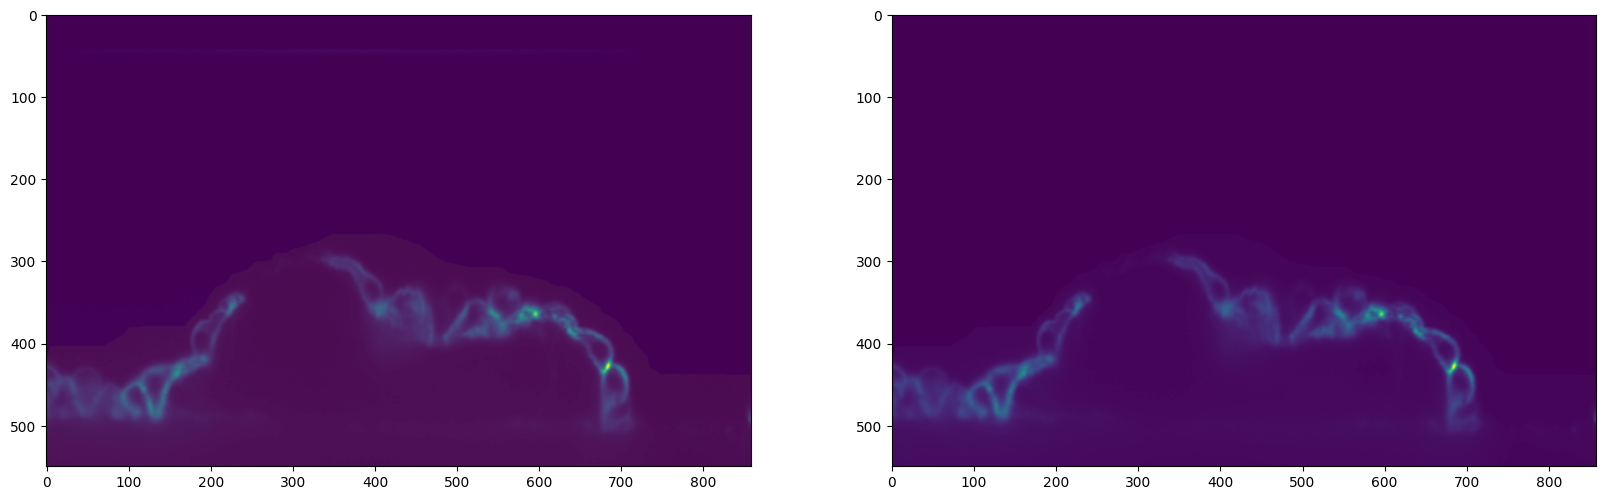

In [199]:
plt.figure(figsize=(20, 10))
y = 350
plt.subplot(121)
plt.imshow(image_r[y])
plt.imshow(hull_top_line_r[y], alpha=0.05)
plt.subplot(122)
plt.imshow(image_r_cut[y])

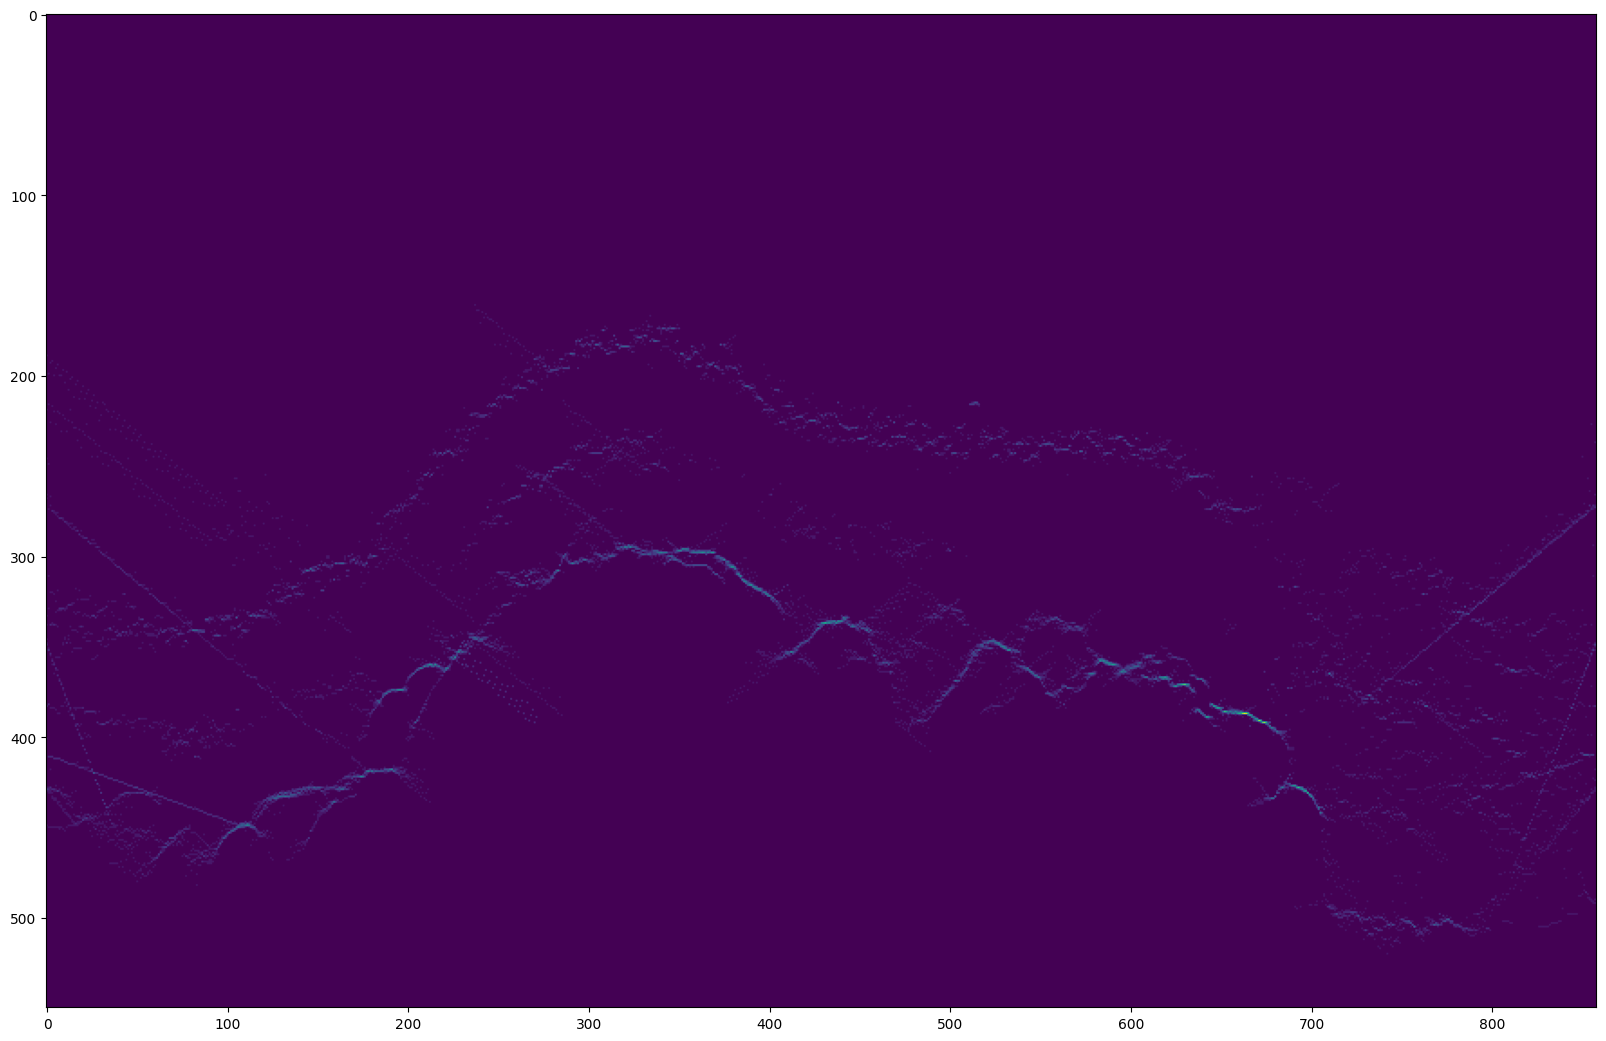

In [208]:
epithelial_dots_r_y = epithelial_dots_r[y]
gaussian_dots_r_y = gaussian_dots_r[y]
image_r_y = image_r[y]

slice_dots = shape_finder_2D_v4(image_r_y, gaussian_dots_r_y, angle=40, moveLine=60)

plt.figure(figsize=(20,20))
plt.imshow(slice_dots)

In [206]:
apical_dots_r = Parallel(n_jobs=-1)(delayed(shape_finder_2D_v4)(im, i) for im, i in zip(common_functions.normalize_image(image_r), common_functions.normalize_image(gaussian_dots_r)))
apical_dots = np.transpose(apical_dots_r, axes=(1,2,0))
tiff.imwrite(f'{wd}_dotsv4____.tif', common_functions.normalize_image(apical_dots, 255).astype(np.uint16))


In [4]:
time_dome = str(3)
folder_and_dome = str('./../../../../Desktop/dome70_tp'+time_dome+'_fallingline/70_denoised_tp')
wd = folder_and_dome + time_dome

apical_dots_r = sk.io.imread(wd+'_dotsv4____.tif')
# apical_dots_r = common_functions.get_image_r(apical_dots_r)

In [100]:
apical_dots = np.transpose(apical_dots_r, axes=(1,2,0))
# apical_dots = apical_dots[::-1]

In [101]:
max_intensity_indices = np.argmax(apical_dots, axis=0)

417
0


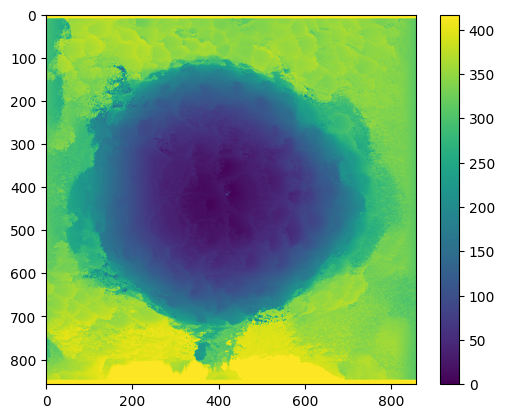

In [103]:
max_intensity_indices[max_intensity_indices == 0] = max_intensity_indices.max()
max_intensity_indices = common_functions.normalize_image(max_intensity_indices, (max_intensity_indices.max()-max_intensity_indices.min())).astype(np.uint16)
plt.imshow(max_intensity_indices)
plt.colorbar()
print(max_intensity_indices.max())
print(max_intensity_indices.min())

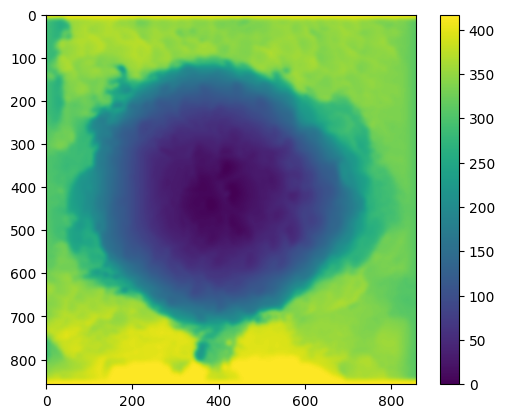

In [114]:
blurred_mii = common_functions.gaussian_2D(max_intensity_indices, 5)
blurred_mii = common_functions.normalize_image(blurred_mii, (max_intensity_indices.max()-max_intensity_indices.min())).astype(np.uint16).astype(np.uint16)
plt.imshow(blurred_mii)
plt.colorbar()

In [115]:
height_3d = np.zeros(apical_dots.shape)
height_3d_blurred = np.zeros(apical_dots.shape)
height_3d[max_intensity_indices[None, :, :], np.arange(apical_dots.shape[1])[None, :, None], np.arange(apical_dots.shape[2])] = 1
height_3d_blurred[blurred_mii[None, :, :], np.arange(apical_dots.shape[1])[None, :, None], np.arange(apical_dots.shape[2])] = 1

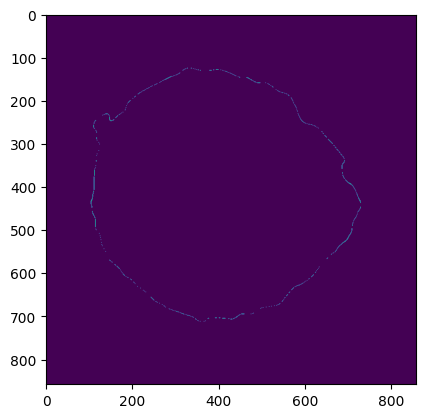

In [116]:
plt.imshow(height_3d_blurred[200])

In [111]:
tiff.imwrite(f'{wd}__heightmap3d_blurred.tif', common_functions.normalize_image(height_3d_blurred, 255).astype(np.uint16))
tiff.imwrite(f'{wd}__heightmap3d.tif', common_functions.normalize_image(height_3d, 255).astype(np.uint16))